# Exploratory Data Analysis

We see 9 different files, each with numerous transactions along with other metadata.

Let us drill down and see what we can find. 

In [1]:

#%%html
#<style>
#div.input {
#    display:none;
#}
#</style>

import pandas as pd
import glob

import matplotlib.pyplot as plt


import seaborn as sns

import datetime
import numpy as np

Importing files

In [2]:
files = glob.glob("data/*.csv")

In [3]:
columns = ['sku', 'brand', 'cat', 'bill', 'store', 'date', 'type', 'mrp', 'price', 'qty']

The 'source' column below is a marker to indicate file origin of the observation 

In [4]:
#Helper function to read multiple csv files and store it in a dictionary. Found in helper.py

from helper import read_files

In [5]:
df_dict = read_files(files, columns)

#    

##### Question 1 - The data is split into 9 files. Does it mean anything? 

In [6]:
#Helper function to test for overlap in the different files. Found in helper.py

from helper import overlap

In [7]:
#A few random checks for overlaps

overlap(df_dict['df1'], df_dict['df2'], 'sku')

'Overlaps found for sku'

In [8]:
overlap(df_dict['df1'], df_dict['df6'], 'brand')

'Overlaps found for brand'

In [9]:
overlap(df_dict['df4'], df_dict['df7'], 'bill')

'There is no overlap'

##### Answer-  It appears that the transactions are put into different files on the basis of different bill numbers

We assume that other than this, there is not much difference between the transactions in the files.

Hence, we are going to concatenate all the 9 files into one big file. 

In [10]:
df = pd.concat(df for df in df_dict.values())

In [11]:
# Overview of data

In [12]:
num_skus = df['sku'].nunique()

num_cats = df['cat'].nunique()

num_stores = df['store'].nunique()

num_bills = df['bill'].nunique()

num_days = df['date'].nunique()

start_date, end_date = df['date'].min(), df['date'].max()

print("There are {} unique SKUs across {} categories in {} stores.\n".format(num_skus, num_cats, num_stores))

print("The number of separate bills are {} recorded on {} days, starting from {} to {}.".format(num_bills, num_days, start_date, end_date))

There are 4289 unique SKUs across 11 categories in 6 stores.

The number of separate bills are 27191 recorded on 424 days, starting from 2017-01-01 to 2018-02-28.


#     

### Data cleaning and formatting

We keep store number only instead of the string

In [13]:
df['store'] = df['store'].apply(lambda x: x[-1])

###### 1) Handling duplicate values

In [14]:
num_duplicated = df.duplicated(keep='first').sum()

print("There are {} duplicate rows".format(num_duplicated))

There are 3889 duplicate rows


We drop the duplicate rows on second occurrence 

In [15]:
df = df.drop_duplicates(keep="first")

###### 2) Handling missing values

In [16]:
df.isna().sum()

sku        0
brand     11
cat        9
bill       0
store      0
date       0
type       0
mrp        0
price      0
qty        0
source     0
dtype: int64

###### Only brand and cat columns have missing values. Let's investigate further. 

In [17]:
# Subset where brand is NaN

df[df['brand'].isnull()].head()

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source
10,SKU0726,NaN,Cat01,BILL02585,6,2017-07-19,Sale,54.67,54.67,1,9
29,SKU2585,NaN,NaN,BILL09133,3,2017-09-09,Sale,2.60,2.60,1,4
1278,SKU2649,NaN,NaN,BILL09643,3,2017-09-06,Sale,8.00,8.00,1,4
1372,SKU2653,NaN,NaN,BILL09736,3,2017-09-07,Sale,30.00,30.00,1,4
1373,SKU2649,NaN,NaN,BILL09737,3,2017-09-07,Sale,8.00,8.00,1,4


###### Instead of throwing the data away, we replace missing brands by 'UnkBRAND' and missing categories by 'UnkCAT'

In [18]:
df.loc[df['brand'].isnull(), 'brand'] = 'UnkBRAND'

df.loc[df['cat'].isnull(), 'cat'] = 'UnkCAT'

###### 3) Extracting day, month, dayofweek and weekend flag from date

In [19]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = pd.DatetimeIndex(df['date']).day

df['month'] = pd.DatetimeIndex(df['date']).month_name()

df['dayofweek'] = pd.DatetimeIndex(df['date']).day_name()

weekend_days = ['Saturday', 'Sunday']

df['weekend'] = np.where(df['dayofweek'].isin(weekend_days), 1, 0)

df['weekno'] = df.date.dt.week

#    

###### Question - Notice that there are transactions with zero quantity. Examining the dataset confirms this. 
###### What do we do here? 

In [20]:
zero_qty = df[df['qty'] == 0]

zero_qty.head()

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source,day,month,dayofweek,weekend,weekno
10122,SKU0651,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10123,SKU0663,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10124,SKU0630,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10125,SKU0635,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10126,SKU0634,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46


###### Answer - Zero quantity transactions don't make sense. Also, their MRP and price are equal (at 1.33), even though they are different SKUs. This suggests it is probably noise. So we remove these transactions. 

In [21]:
df = df[df['qty'] != 0]

#     

### Cursory EDA

###### Question - Is there anything peculiar about the SKUs that are recorded as sold at zero quantity? 

In [22]:
zero_qty_skus = zero_qty.sku.unique()

zero_qty_skus

array(['SKU0651', 'SKU0663', 'SKU0630', 'SKU0635', 'SKU0634', 'SKU0627',
       'SKU0638', 'SKU0632', 'SKU0667', 'SKU0637', 'SKU0653', 'SKU0633',
       'SKU0639', 'SKU0642', 'SKU0641', 'SKU0636', 'SKU0650', 'SKU0654',
       'SKU0648', 'SKU2134'], dtype=object)

In [23]:
for sku in zero_qty_skus:
    print("Price: ", set(df[df['sku'] == sku]['price']),
         "Qty: ", set(df[df['sku'] == sku]['qty']))

Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}


###### Answer - All of them are priced at either 0 or 1.33, and the quantity fluctuates. 

###### For further investigation we need more information about the SKUs from the source, but since this is an anonymous dataset, this is not possible. 

###### Hence, even though they appear to be noise (at a cursory glance), we retain these transactions for now.

#  

We see if there is overcharging (where price is greater than MRP)

In [24]:
overcharged = df[df['price'] > df['mrp'] ]

print(overcharged.shape[0])

overcharged[['mrp', 'price']].tail()

1665


,mrp,price
11420,20.00,22.00
11428,22.00,24.00
11431,55.33,60.00
11432,88.00,96.00
11496,88.67,96.67


Overcharging does happen on 1665 transactions. Some of these SKUs have MRP = 0.

One possible explanation for this is that these SKUs were intended to be discounted, but were sold at a higher price, mistakenly or otherwise.

For the sake of simplicity, we 'rectify' this issue by forcing the MRP to match the price (since price is what the customer has already paid). 

###### We assume the MRP was entered wrongly and so the discount is zero. Not recommended in an actual setting.  

In [25]:
df['mrp'] = np.where(df.price > df.mrp, df.price, df.mrp)

#   

###### Some of the SKUs have MRP.= 0. We investigate it. 

In [26]:
zero_mrp = df[df['mrp'] == 0]

zero_mrp_skus = zero_mrp.sku.unique().tolist() 

In [27]:
print("{} transactions have zero MRP, which is recorded under {} different SKUs.".format(zero_mrp.shape[0], len(zero_mrp_skus)))

699 transactions have zero MRP, which is recorded under 123 different SKUs.


###### Question - Are these SKUs always sold for MRP = 0 every time?    

In [28]:
zero_mrp_skus_avg_mrps = df[(df['sku'].isin(zero_mrp_skus)) & (df['mrp'] != 0)].groupby('sku')['mrp'].agg(lambda x : np.mean(x))

zero_mrp_skus_avg_mrps

sku
SKU3676    0.01
Name: mrp, dtype: float64

###### Answer - Just one transaction with an MRP of 0.01. This is almost certainly an anomaly. 

###### So we can discard all MRPs that are 0. 

In [29]:
df =  df[df['mrp'] != 0]

###### Question - How many transactions are sales and how many are returns? 

In [30]:
num_trans_type = df.groupby('type')['qty'].count()

qty_trans_type = df.groupby('type')['qty'].sum()

num_trans_type, qty_trans_type

(type
 Return      164
 Sale      58312
 Name: qty, dtype: int64, type
 Return     -172
 Sale      60650
 Name: qty, dtype: int64)

###### Answer - There is are 164 transactions that are under returns, containing 172 return items. 

###### We can remove the return transactions, only for the EDA part. 

In [31]:
df = df[df['type'] == 'Sale']

In [32]:
###### Creating total price, discount and percentage discount features

In [33]:
df['total'] = df['price'] * df['qty']

df['discount'] = df['mrp'] - df['price']

df['perc_discount'] = ((df['mrp'] - df['price']) / df['mrp']) * 100

df['perc_discount'] = np.where(df['perc_discount'] == -np.inf, 0, df['perc_discount'])




#    

### Metric 1: Total transaction count

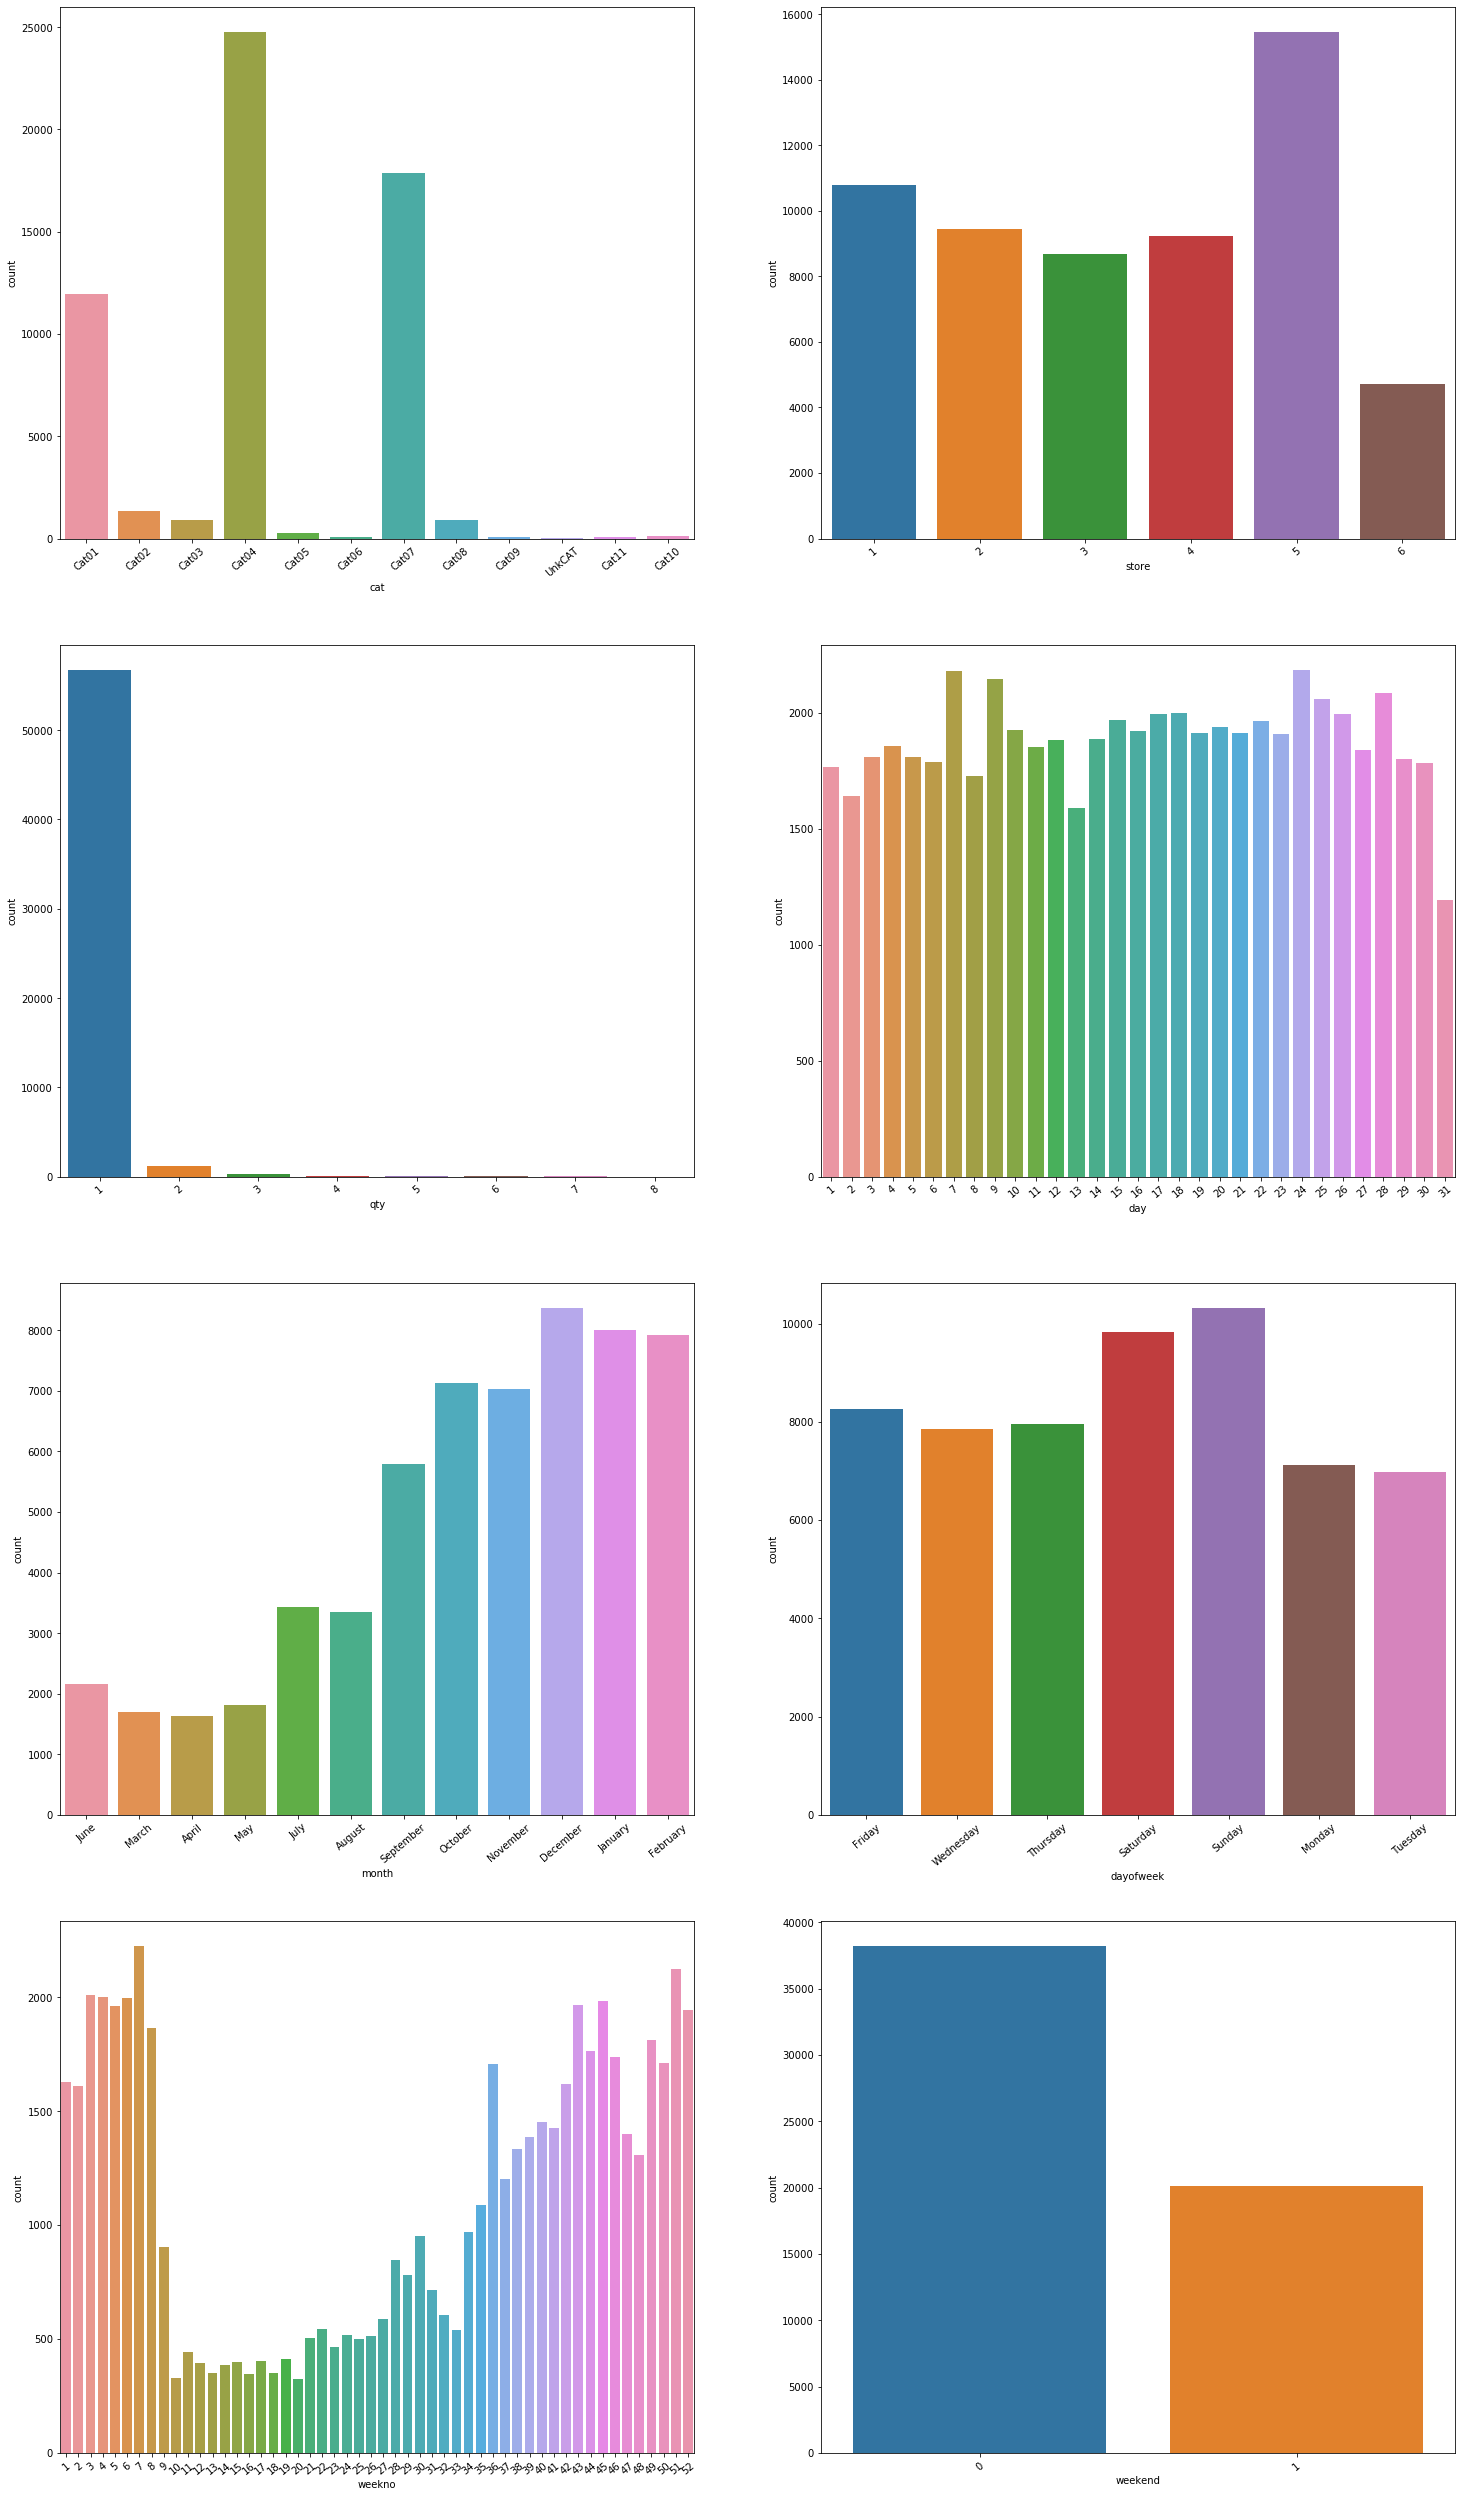

In [34]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

#plt.setp(fig.xaxis.get_majorticklabels(), rotation=45)

#axs.tickp


cat_trans_count_plot = sns.countplot(df['cat'], ax=axs[0,0])
cat_trans_count_plot.set_xticklabels(cat_trans_count_plot.get_xticklabels(), rotation=40);

store_trans_count_plot = sns.countplot(df['store'], ax=axs[0,1])
store_trans_count_plot.set_xticklabels(store_trans_count_plot.get_xticklabels(), rotation=40);
    
qty_trans_count_plot = sns.countplot(df['qty'], ax=axs[1,0])
qty_trans_count_plot.set_xticklabels(qty_trans_count_plot.get_xticklabels(), rotation=40);

day_trans_count_plot = sns.countplot(df['day'], ax=axs[1,1])
day_trans_count_plot.set_xticklabels(day_trans_count_plot.get_xticklabels(), rotation=40);

month_trans_count_plot = sns.countplot(df['month'], ax=axs[2,0])
month_trans_count_plot.set_xticklabels(month_trans_count_plot.get_xticklabels(), rotation=40);

dayofweek_trans_count_plot = sns.countplot(df['dayofweek'], ax=axs[2,1])
dayofweek_trans_count_plot.set_xticklabels(dayofweek_trans_count_plot.get_xticklabels(), rotation=40);

weekno_trans_count_plot = sns.countplot(df['weekno'], ax=axs[3,0])
weekno_trans_count_plot.set_xticklabels(weekno_trans_count_plot.get_xticklabels(), rotation=40);

weekend_trans_count_plot = sns.countplot(df['weekend'], ax=axs[3,1])
weekend_trans_count_plot.set_xticklabels(weekend_trans_count_plot.get_xticklabels(), rotation=40);

#for ax in fig.axes:
 #   plt.xticks(rotation=45)





###### Key takeaways - 

1) SKUs of Category 4, 7 and 1 are highest-selling by transaction count. Store 5 has the most number of transactions. 

2) Most SKUs are sold in singular quantities.  

3) Sales spike in the weekends. Monday is the least busy day. 

4) There is a sudden slump after week 9 all the way to week 33. Needs more investigating. 

5) The ratio of weekend to weekday transaction count is almost 1:2.     

#   

### Metric 2:  Total quantity of SKU

In [35]:
from helper import barplot

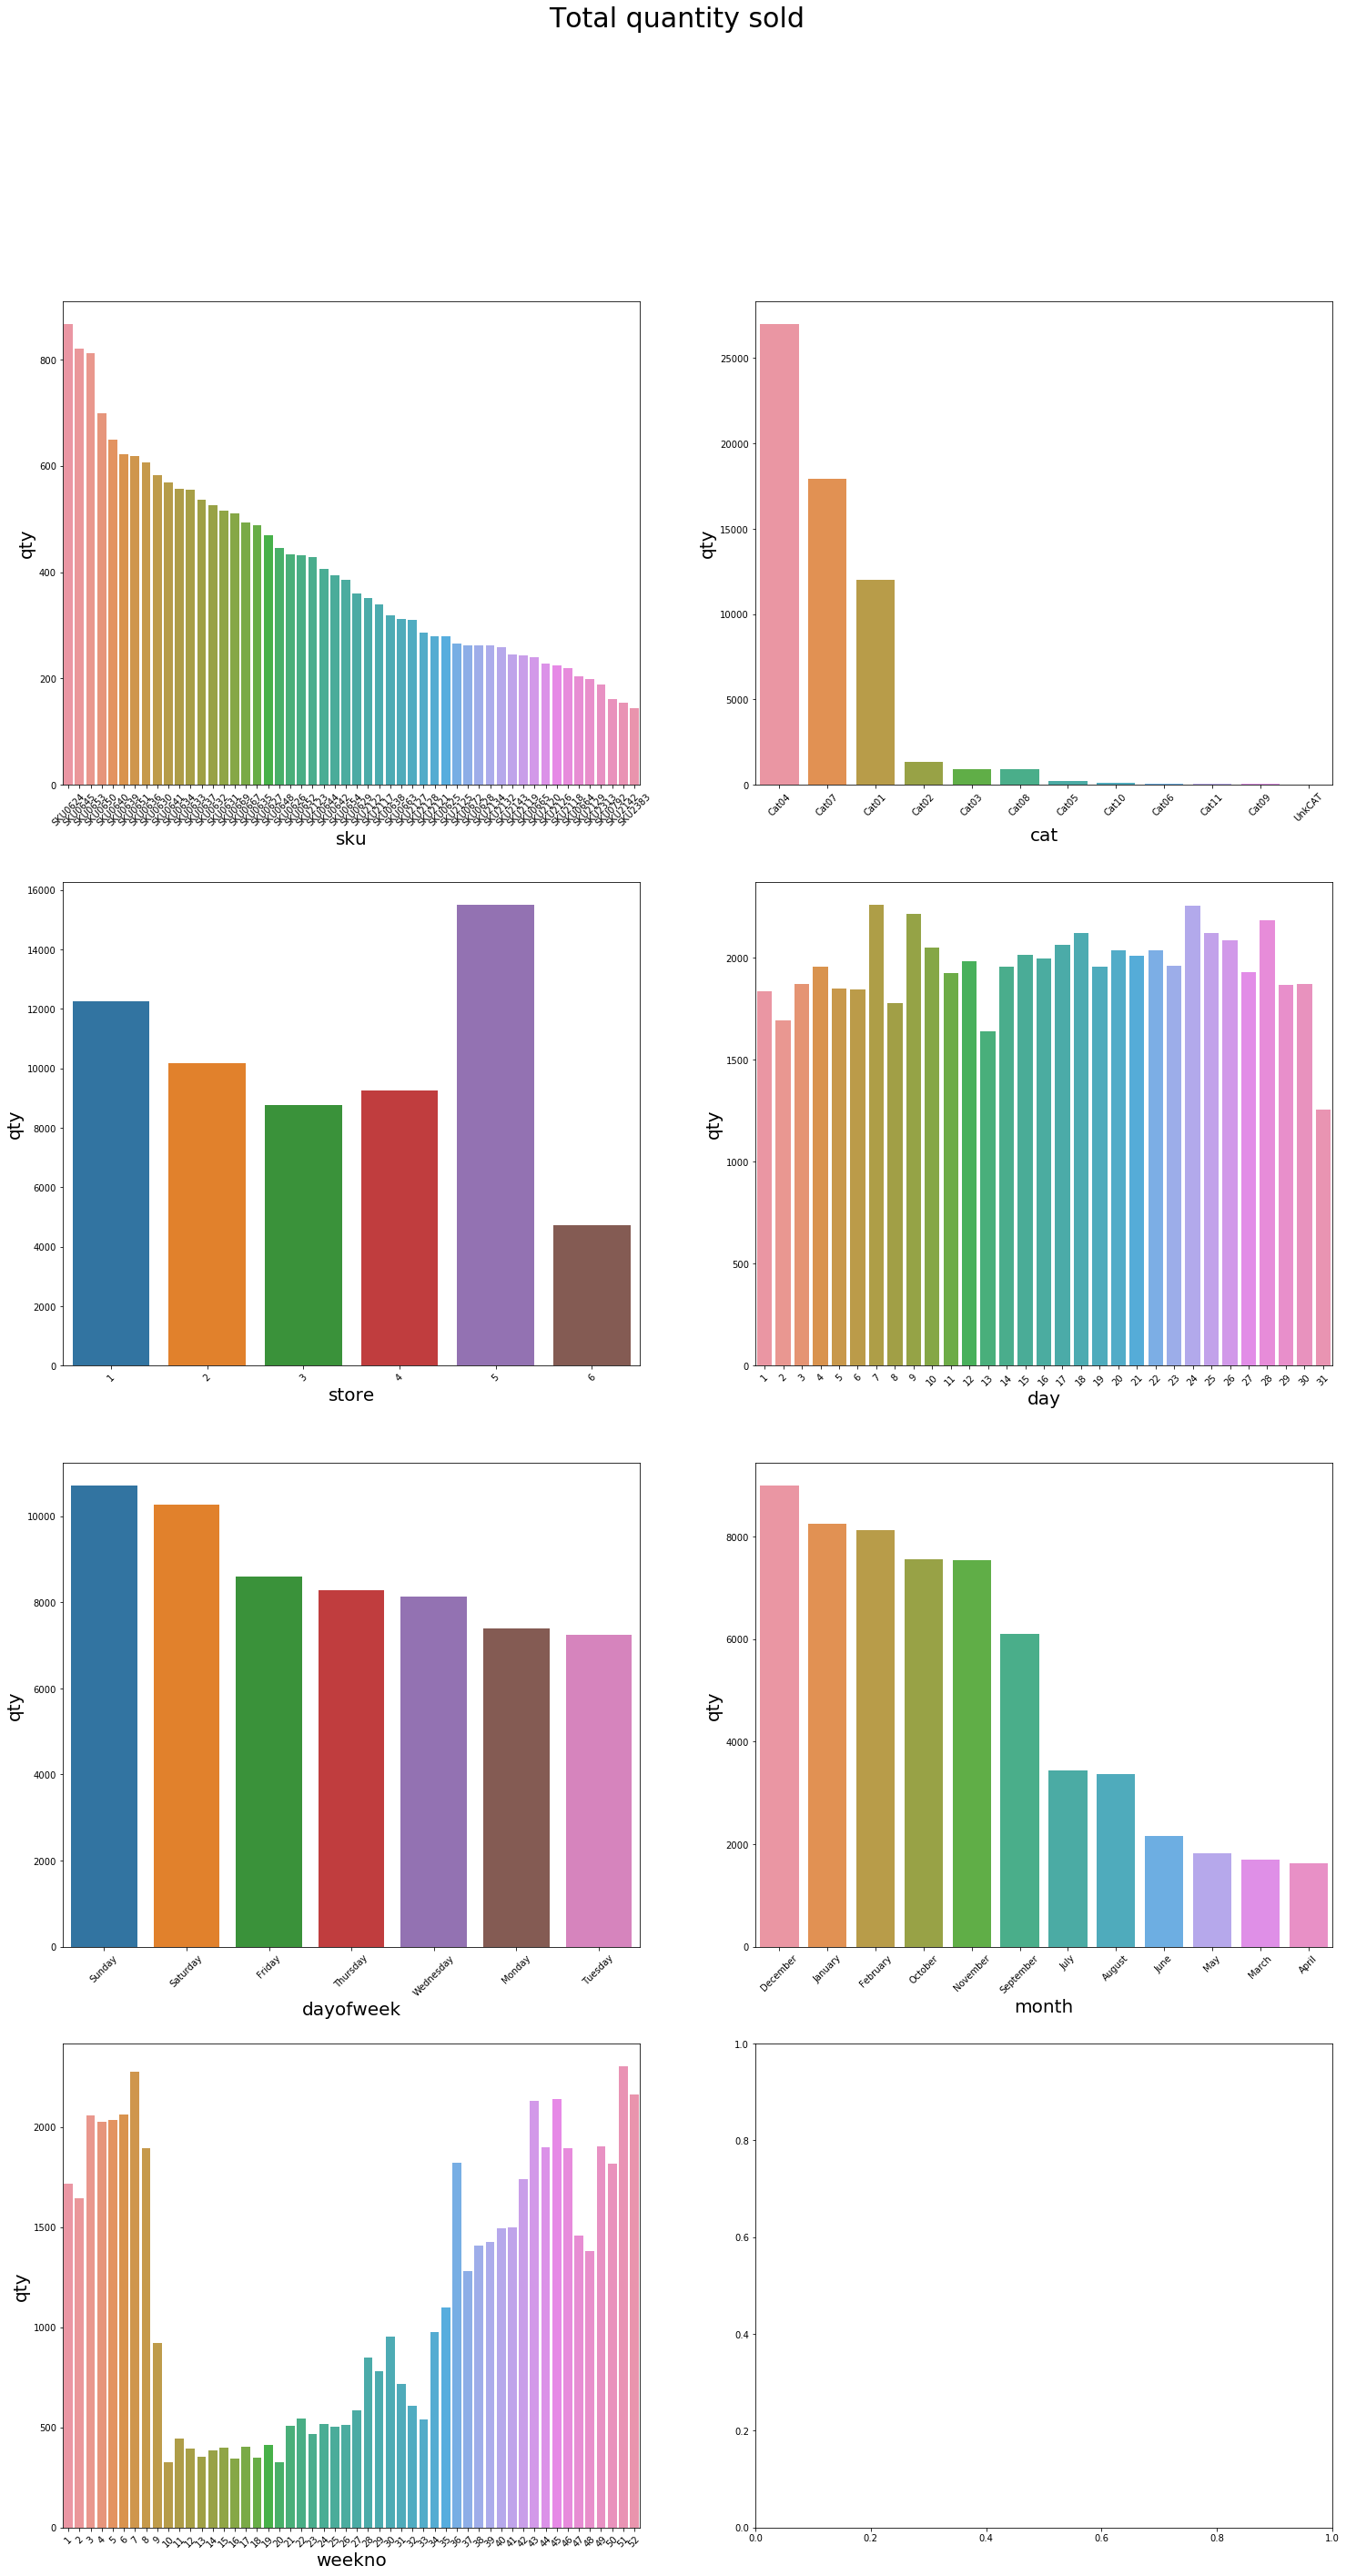

In [36]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

title = fig.suptitle("Total quantity sold", size = 30)

tot_qty_per_sku, tot_qty_per_sku_plot = barplot(df, 'sku', 'qty', 'sum', axs[0,0], size=20)

tot_qty_per_cat, tot_qty_per_cat_plot = barplot(df, 'cat', 'qty', 'sum', axs[0,1])

tot_qty_per_store, tot_qty_per_store_plot = barplot(df, 'store', 'qty', 'sum', axs[1,0])

tot_qty_per_day, tot_qty_per_day_plot = barplot(df, 'day', 'qty', 'sum', axs[1,1])

tot_qty_per_dayofweek, tot_qty_per_dayofweek_plot = barplot(df, 'dayofweek', 'qty', 'sum', axs[2,0])

tot_qty_per_month, tot_qty_per_month_plot = barplot(df, 'month', 'qty', 'sum', axs[2,1])

tot_qty_per_weekno, tot_qty_per_weekno_plot = barplot(df, 'weekno', 'qty', 'sum', axs[3,0])




In [37]:
print("The top 10 selling SKUs by total quantity are \n{}".format(tot_qty_per_sku[:10]))

The top 10 selling SKUs by total quantity are 
         qty
sku         
SKU0624  867
SKU0645  821
SKU0653  812
SKU0650  699
SKU0640  649
SKU0639  622
SKU0651  619
SKU0636  606
SKU0630  582
SKU0641  569


In [38]:
top_selling_sku_cats = df[df['sku'].isin(tot_qty_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by total sell count are as follows: \n{}".format(top_selling_sku_cats))

The categories of the top 20 SKUs by total sell count are as follows: 
Cat04    18644
Cat07      144
Cat10       90
Name: cat, dtype: int64


In [39]:
top_selling_sku_stores = df[df['sku'].isin(tot_qty_per_sku.index)]['store'].value_counts()

print("The stores of the top 20 SKUs by total sell count are as follows: \n{}".format(top_selling_sku_stores))

The stores of the top 20 SKUs by total sell count are as follows: 
5    4965
1    4588
2    3725
4    3200
3    2376
6      24
Name: store, dtype: int64


###### Key takeaways - 

1. All of the top 20 selling SKUs belong to category 4. Approx. 30% of them are sold in Store 5 alone. 

2. Category 4 has the highest selling SKUs by quantity overall, followed by Category 7 and Category 1. The rest are very low volume in comparison. 

3. Store 5 has the highest quantities sold overall. Store 6 is by far the lowest. 

4. Weekends have higher sales volume. 

5. There is a slump in sales volume between March to July. This can be seen in the monthwise and weekwise plots. 

###### We pick the highest selling SKU and drill down on it

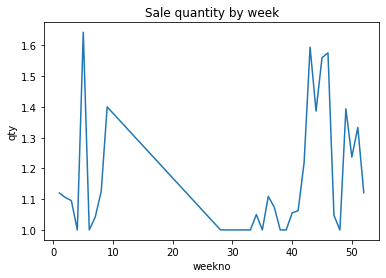

In [70]:
top_sku = tot_qty_per_sku.index[0]

tsku1 = sns.lineplot(x = df[df['sku']==top_sku]['weekno'], y=df[df['sku']==top_sku]['qty'], 
                     ci=None).set_title("Sale quantity by week")

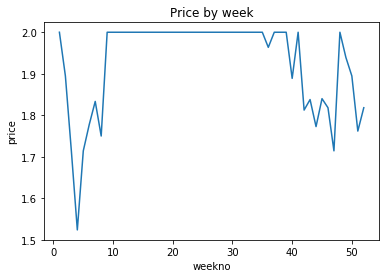

In [73]:
tsku2 = sns.lineplot(x = df[df['sku']==top_sku]['weekno'], y=df[df['sku']==top_sku]['price'], 
                     ci=None).set_title("Price by week")

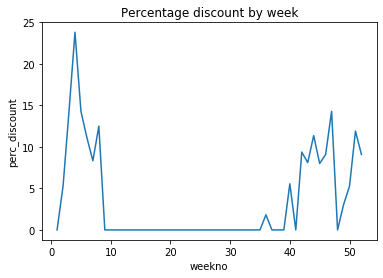

In [72]:
tsku3 = sns.lineplot(x = df[df['sku']==top_sku]['weekno'], y=df[df['sku']==top_sku]['perc_discount'], 
                     ci=None).set_title("Percentage discount by week")

###### From the above 3 plots, we can visually discern a possible link between sale quantity, price and discount.

###### If the price increases, it is usually associated with a decrease in discount and ultimately a decrease in sales.

###### Here, we see that sales are higher towards the beginning and the of the year and bottom-out for the rest of the year. This is similar to the plot we made for all SKUs in Metric 2.

In [92]:
df_sku = df[df['sku']==top_sku]

df_sku.corr()

,mrp,price,qty,day,weekend,weekno,total,discount,perc_discount
mrp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,1.000000,-0.202706,-0.113986,0.022463,0.035442,0.437490,-1.000000,-1.000000
qty,NaN,-0.202706,1.000000,0.012703,0.043553,0.094016,0.637380,0.202706,0.202706
day,NaN,-0.113986,0.012703,1.000000,0.070825,0.115490,-0.082313,0.113986,0.113986
weekend,NaN,0.022463,0.043553,0.070825,1.000000,0.023173,0.060863,-0.022463,-0.022463
weekno,NaN,0.035442,0.094016,0.115490,0.023173,1.000000,0.092858,-0.035442,-0.035442
total,NaN,0.437490,0.637380,-0.082313,0.060863,0.092858,1.000000,-0.437490,-0.437490
discount,NaN,-1.000000,0.202706,0.113986,-0.022463,-0.035442,-0.437490,1.000000,1.000000
perc_discount,NaN,-1.000000,0.202706,0.113986,-0.022463,-0.035442,-0.437490,1.000000,1.000000


#    

### Metric 3: Average quantity  of SKU

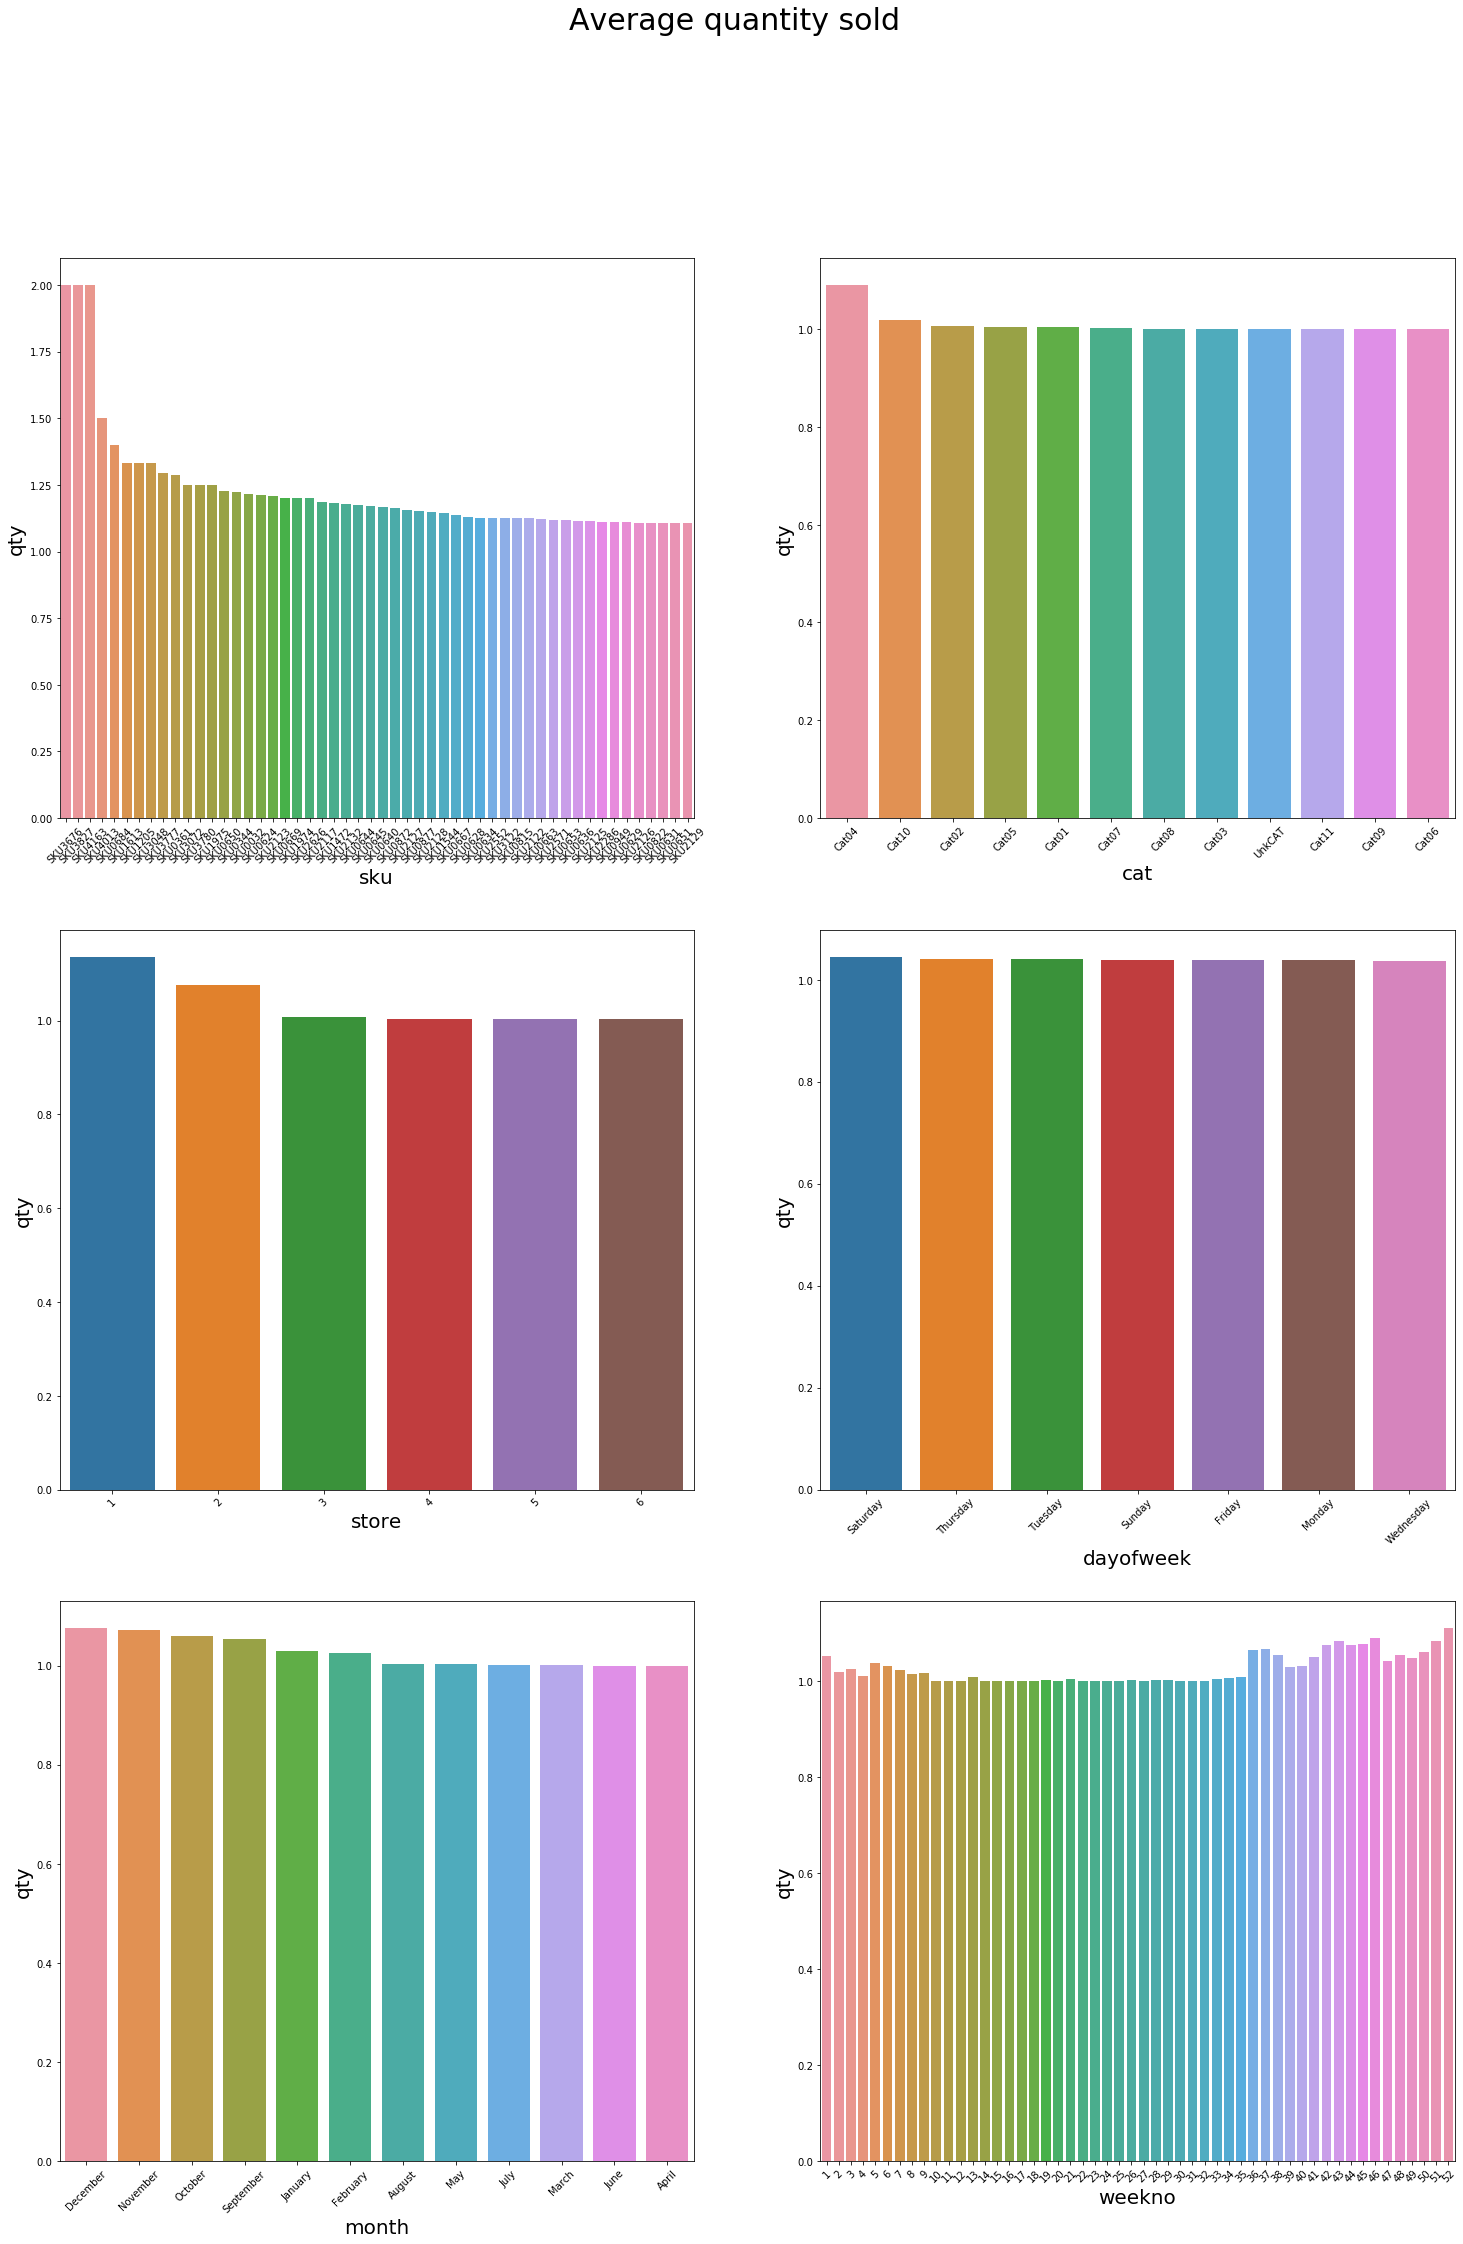

In [74]:
fig, axs = plt.subplots(3, 2, figsize = (25,35))

title = fig.suptitle("Average quantity sold", size = 30)

avg_qty_per_sku, avg_qty_per_sku_plot = barplot(df, 'sku', 'qty', 'avg', axs[0,0])

avg_qty_per_cat, avg_qty_per_cat_plot = barplot(df, 'cat', 'qty', 'avg', axs[0,1])

avg_qty_per_store, avg_qty_per_store_plot = barplot(df, 'store', 'qty', 'avg', axs[1,0])

avg_qty_per_dayofweek, avg_qty_per_dayofweek_plot = barplot(df, 'dayofweek', 'qty', 'avg', axs[1,1])

avg_qty_per_month, avg_qty_per_month_plot = barplot(df, 'month', 'qty', 'avg', axs[2,0])

avg_qty_per_weekno, avg_qty_per_weekno_plot = barplot(df, 'weekno', 'qty', 'avg', axs[2,1])



In [ ]:
print("By average count, the top SKUs are \n{}".format(avg_qty_per_sku[:10]))

#     

### Metric 4: Total revenue

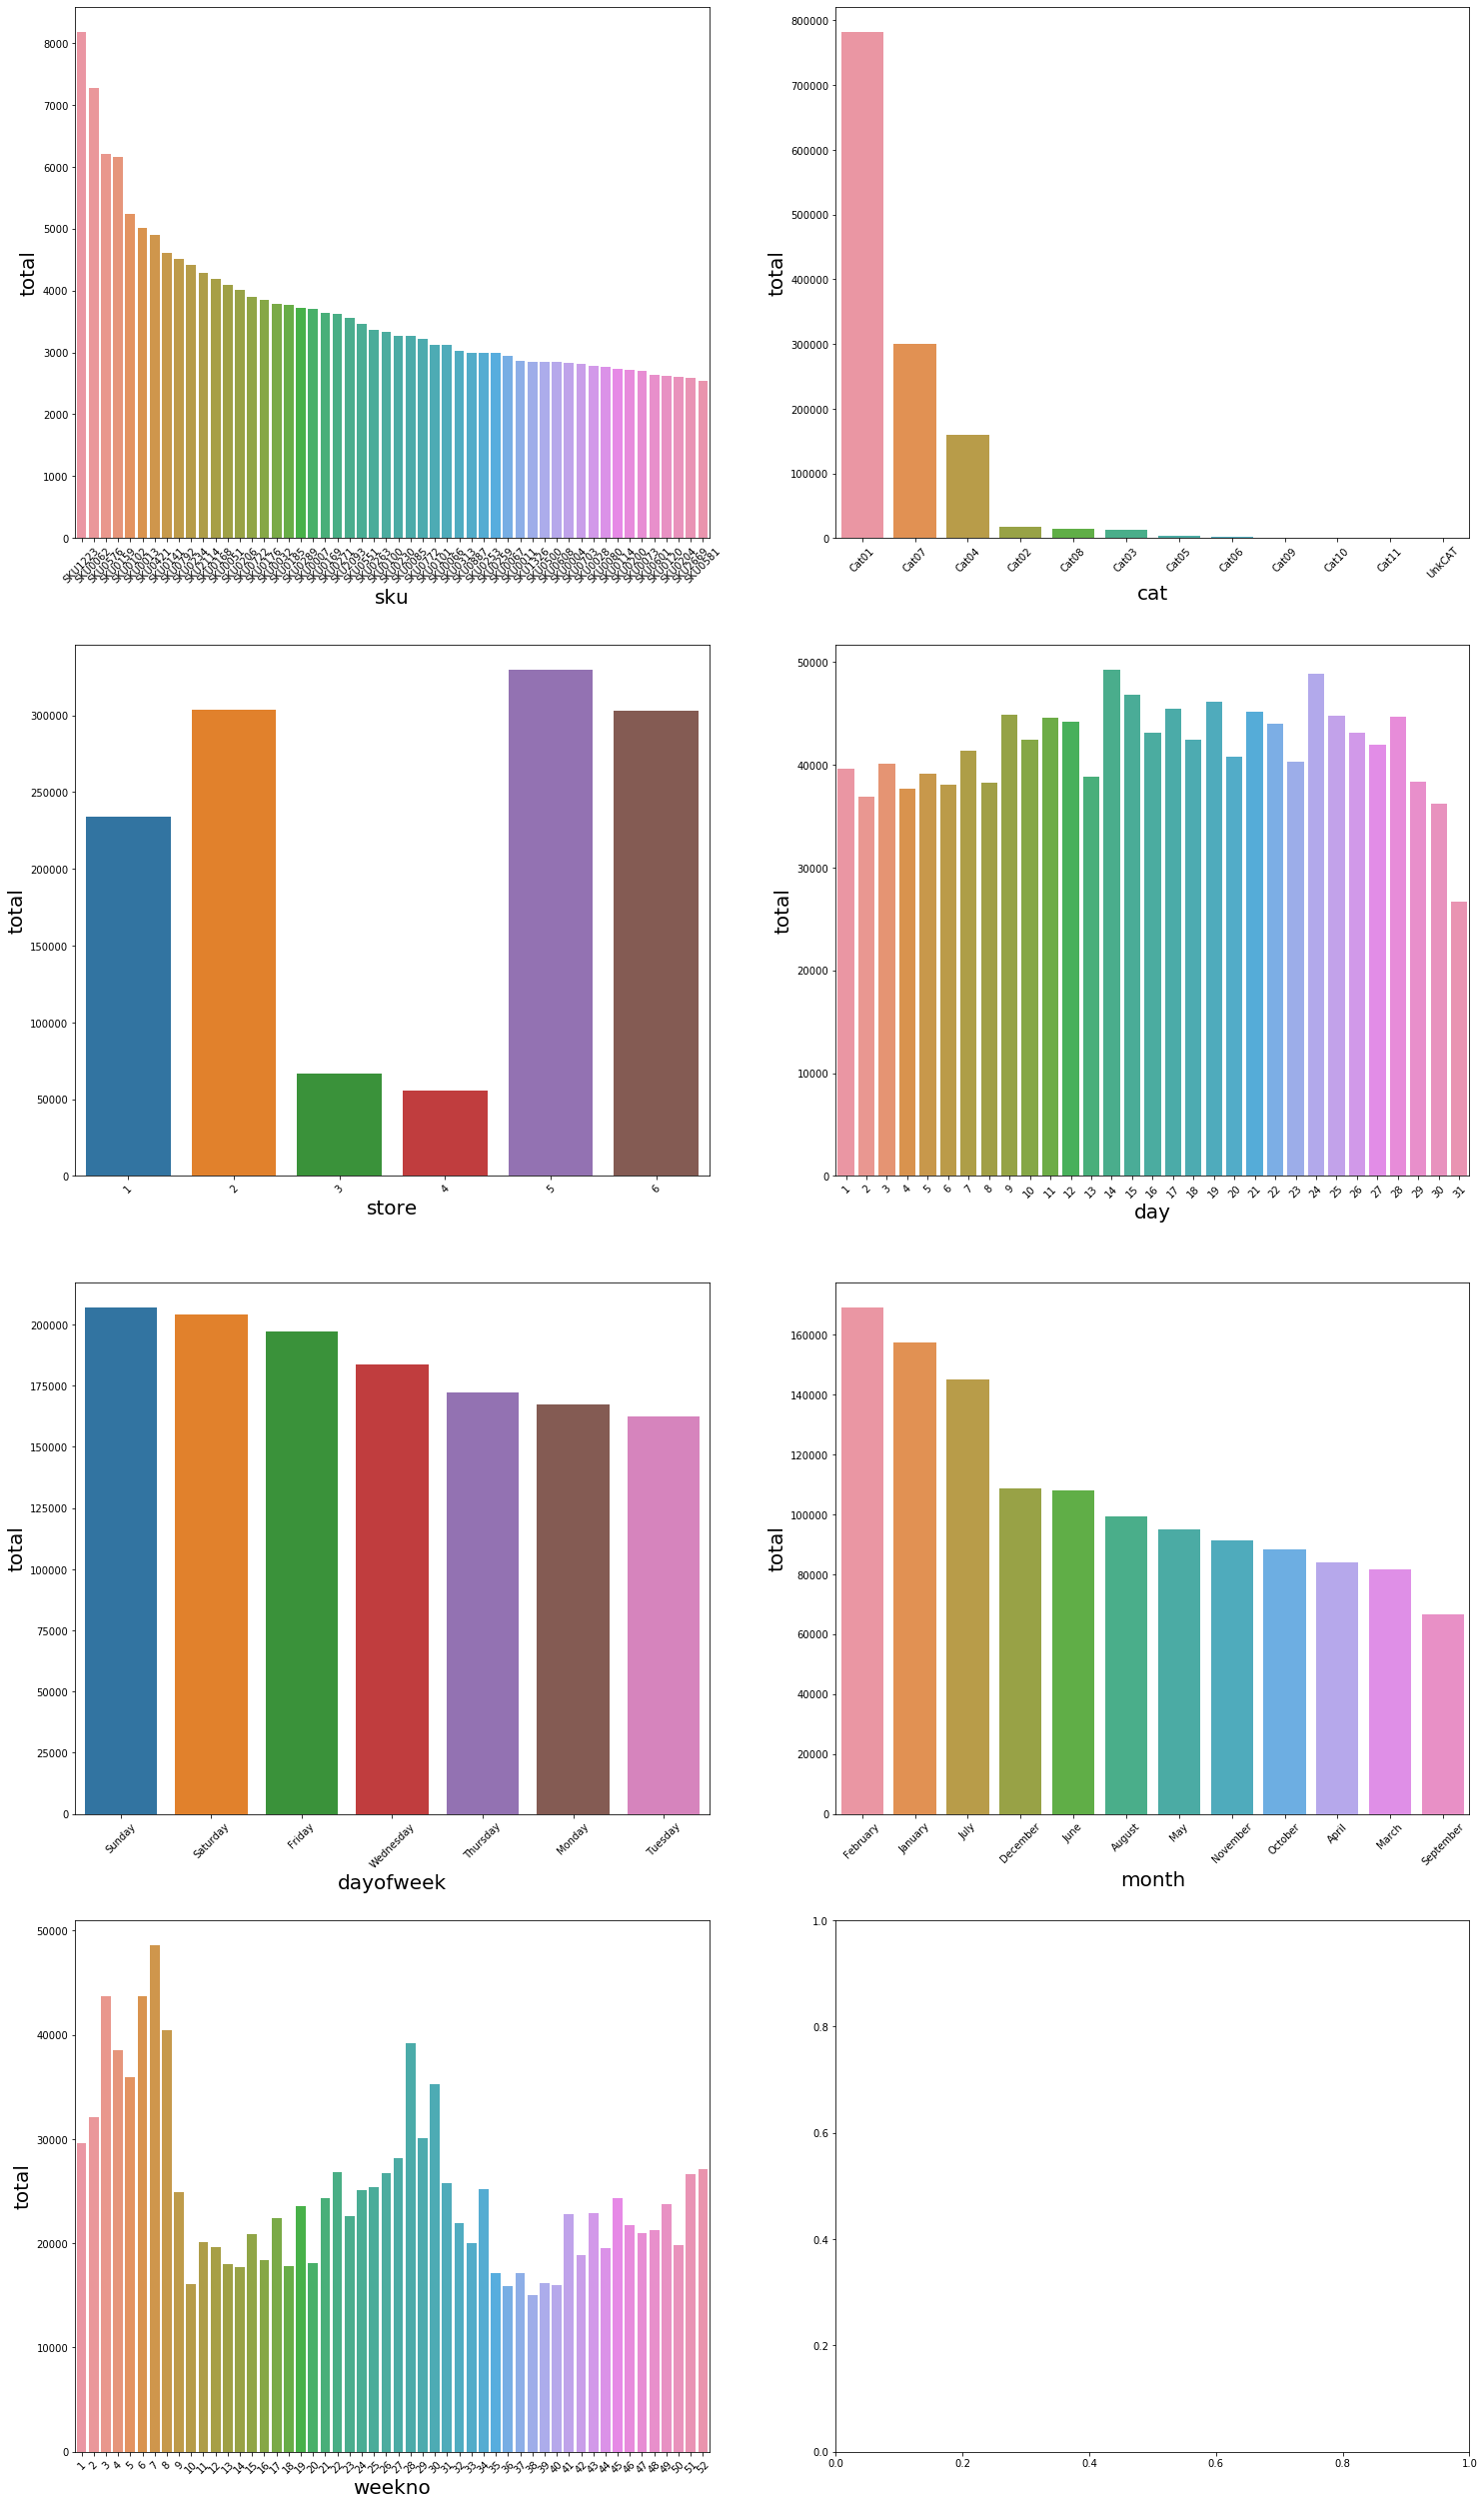

In [75]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

total_per_sku, total_per_sku_plot = barplot(df, 'sku', 'total', 'sum', axs[0,0])

total_per_cat, total_per_cat_plot = barplot(df, 'cat', 'total', 'sum', axs[0,1])

total_per_store, total_per_store_plot = barplot(df, 'store', 'total', 'sum', axs[1,0])

total_per_day, total_per_day_plot = barplot(df, 'day', 'total', 'sum', axs[1,1])

total_per_dayofweek, total_per_dayofweek_plot = barplot(df, 'dayofweek', 'total', 'sum', axs[2,0])

total_per_month, total_per_month_plot = barplot(df, 'month', 'total', 'sum', axs[2,1])

total_per_weekno, total_per_weekno_plot = barplot(df, 'weekno', 'total', 'sum', axs[3,0])

In [ ]:
print("The top 10 SKUs with highest total revenue are \n{}".format(total_per_sku[:10]))

In [ ]:
top_total_sku_cats = df[df['sku'].isin(total_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by total revenue are as follows: \n{}".format(top_total_sku_cats))

In [ ]:
top_total_sku_stores = df[df['sku'].isin(total_per_sku.index)]['store'].value_counts()

print("The stores of the top 20 SKUs by total revenue are as follows: \n{}".format(top_total_sku_stores))

#   

# Metric 5: Discount

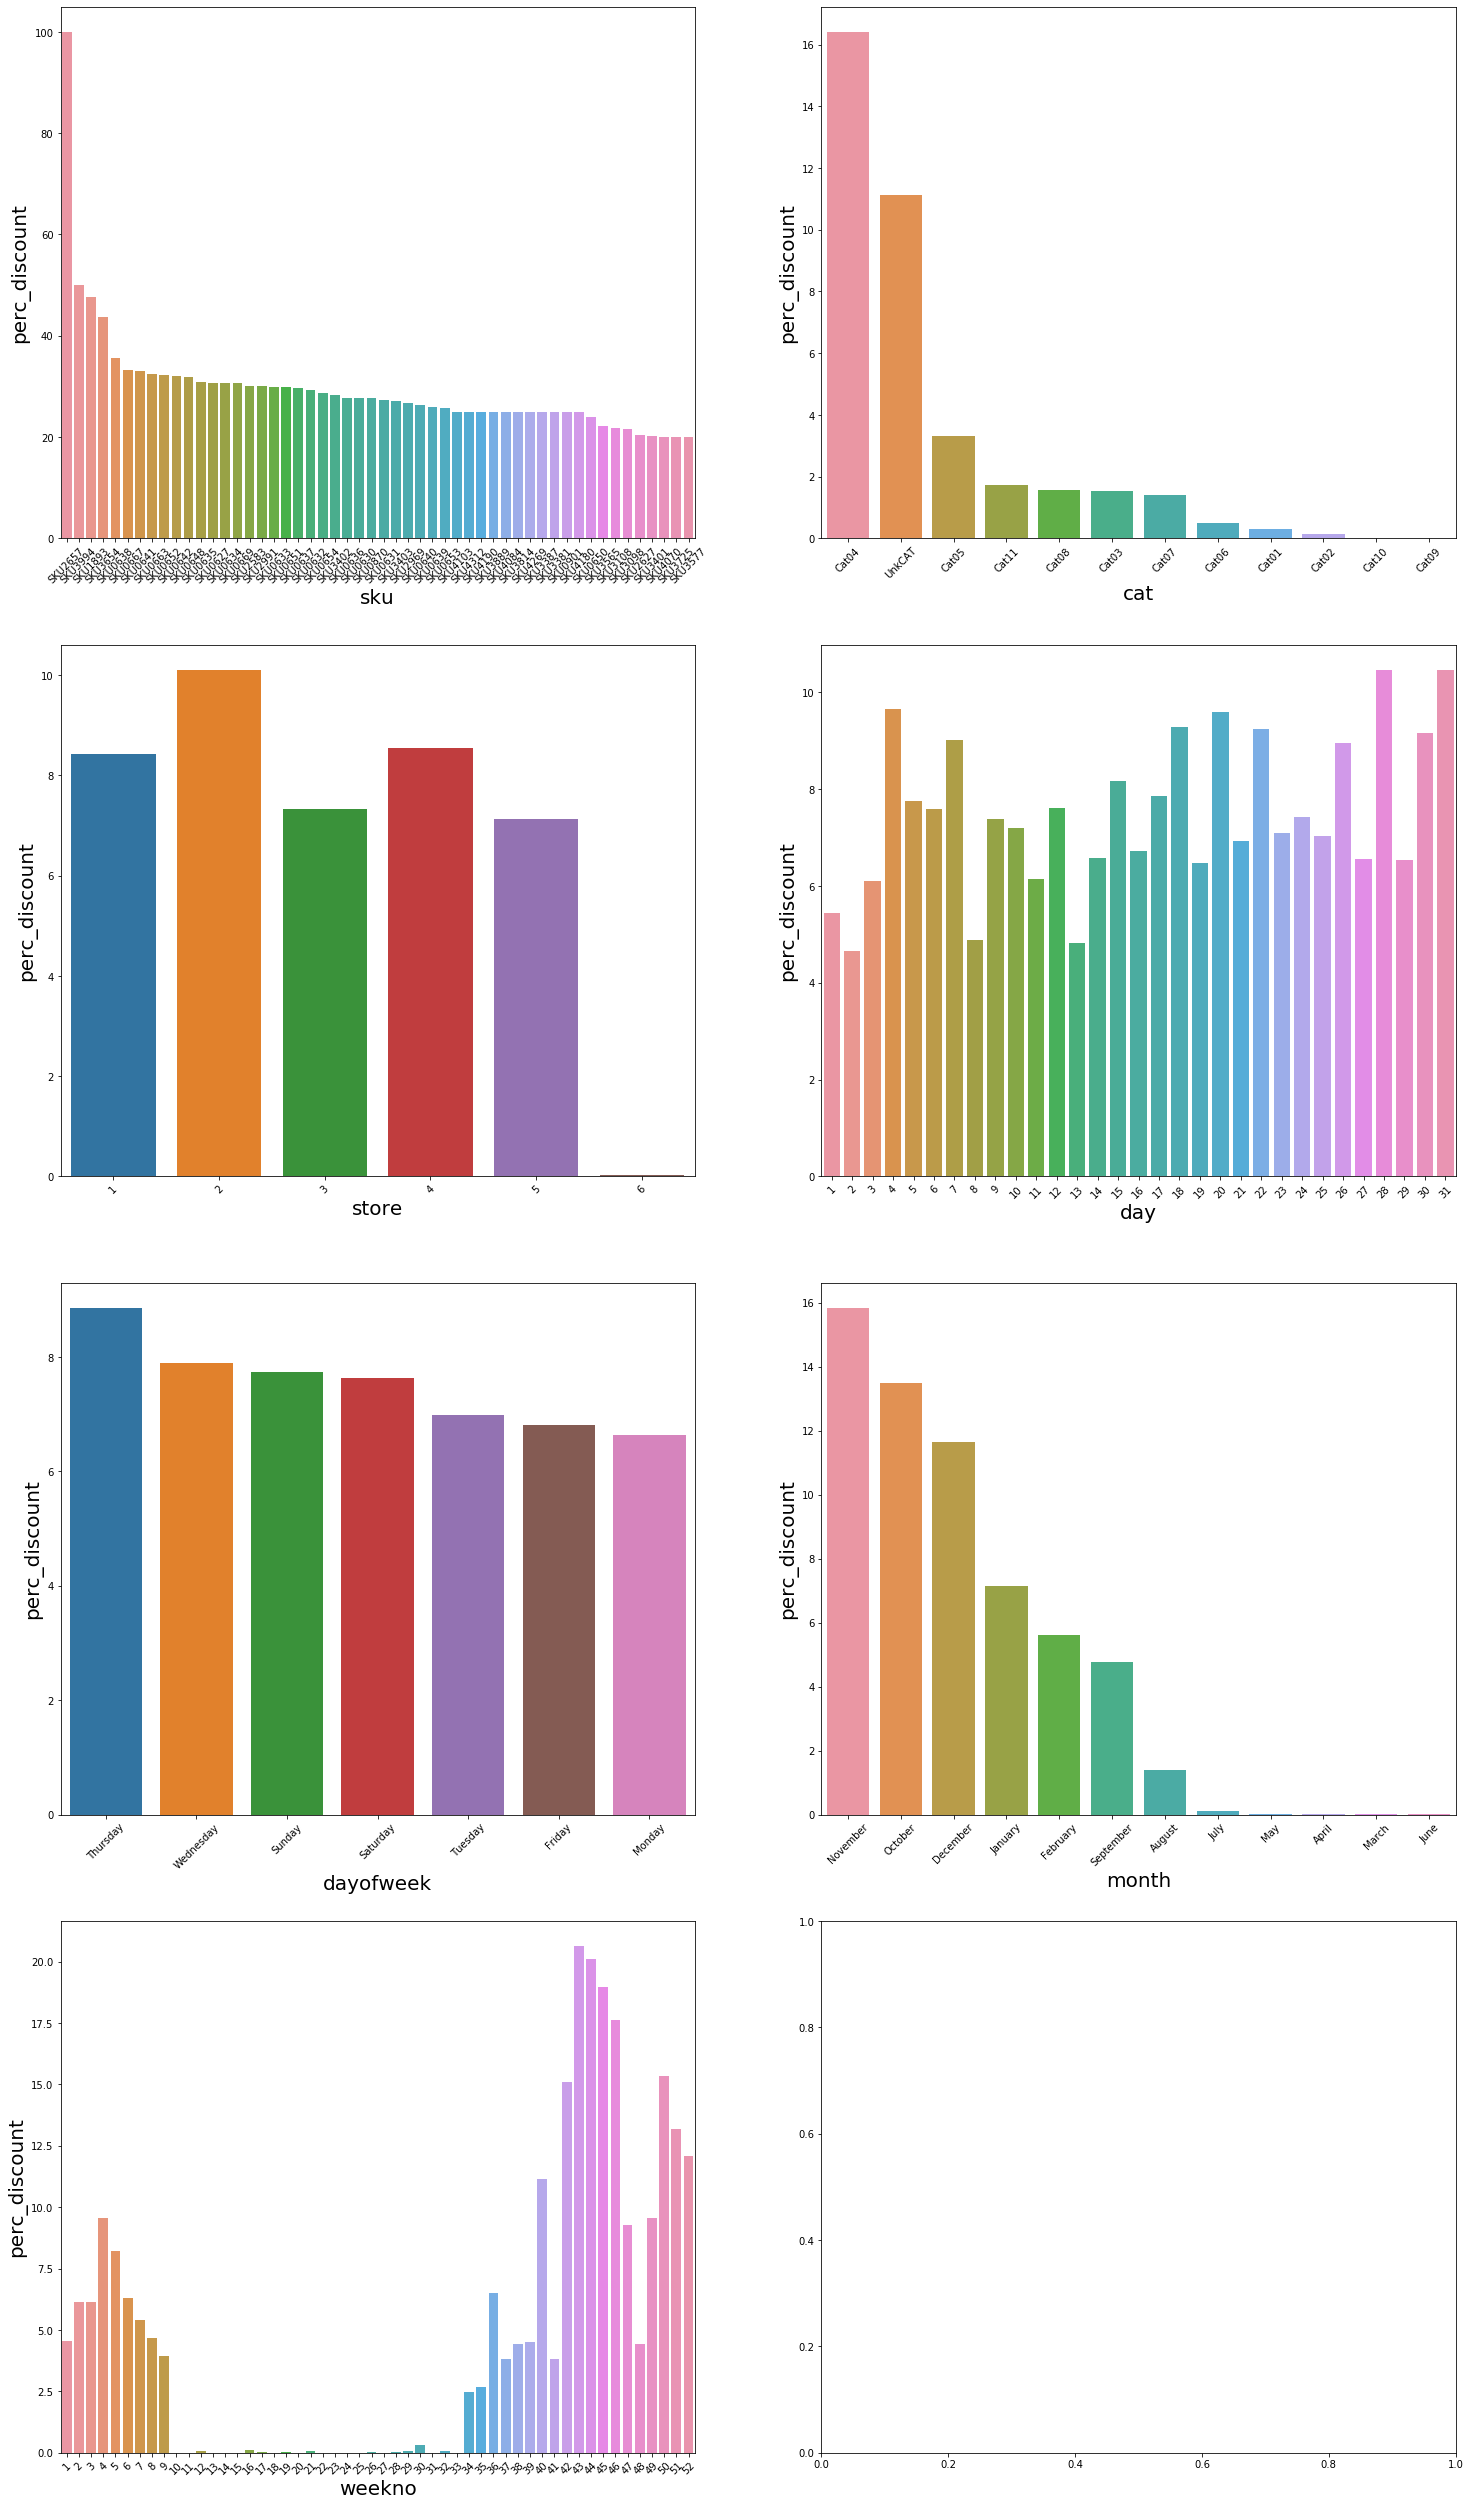

In [76]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

perc_discount_per_sku, perc_discount_per_sku_plot = barplot(df, 'sku', 'perc_discount', 'avg', axs[0,0])

perc_discount_cat, perc_discount_per_cat_plot = barplot(df, 'cat', 'perc_discount', 'avg', axs[0,1])

perc_discount_per_store, perc_discount_per_store_plot = barplot(df, 'store', 'perc_discount', 'avg', axs[1,0])

perc_discount_per_day, perc_discount_per_day_plot = barplot(df, 'day', 'perc_discount', 'avg', axs[1,1])

perc_discount_per_dayofweek, perc_discount_per_dayofweek_plot = barplot(df, 'dayofweek', 'perc_discount', 'avg', axs[2,0])

perc_discount_per_month, perc_discount_per_month_plot = barplot(df, 'month', 'perc_discount', 'avg', axs[2,1])

perc_discount_per_weekno, perc_discount_per_weekno_plot = barplot(df, 'weekno', 'perc_discount', 'avg', axs[3,0])

In [ ]:
print("The top 5 SKUs with highest percentage discount are \n{}".format(perc_discount_per_sku[:5]))

In [ ]:
top_perc_discount_sku_cats = df[df['sku'].isin(perc_discount_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by count are as follows: \n{}".format(top_perc_discount_sku_cats))

In [ ]:
top_perc_discount_sku_stores = df[df['sku'].isin(perc_discount_per_sku.index)]['store'].value_counts()

print("The stores of the top 20 SKUs by count are as follows: \n{}".format(top_perc_discount_sku_stores))

###### Key takeaways -

1. Category 4 is the most discounted. As we saw in Metric 1, Category 4 also has the most number of transactions. The two could be linked. 

2. Discounts are clustered at the beginning and the end of the year and drop steeply in the middle. 

3. Store 2 has the highest average discount percentage. Saturday is the most discounted day on average. 

#    

### Metric 6: Mean selling price per week

In [ ]:
df_mean_price = df.groupby(['sku', 'weekno', 'store', 'month', 'cat'], as_index=False)['price'].mean()

df_mean_price.head()

In [ ]:

fig, axs = plt.subplots(4, 2, figsize = (25,45))

mean_price_per_sku, mean_price_per_sku_plot = barplot(df, 'sku', 'price', 'avg', axs[0,0])

mean_price_per_cat, mean_price_per_cat_plot = barplot(df, 'cat', 'price', 'avg', axs[0,1])

mean_price_per_store, mean_price_per_store_plot = barplot(df, 'store', 'price', 'avg', axs[1,0])

mean_price_per_day, mean_price_per_day_plot = barplot(df, 'day', 'price', 'avg', axs[1,1])

mean_price_per_dayofweek, mean_price_per_dayofweek_plot = barplot(df, 'dayofweek', 'price', 'avg', axs[2,0])

mean_price_per_month, mean_price_per_month_plot = barplot(df, 'month', 'price', 'avg', axs[2,1])

mean_price_per_weekno, mean_price_per_weekno_plot = barplot(df, 'weekno', 'price', 'avg', axs[3,0])

In [ ]:
print("The top 10 SKUs with highest weekly mean selling price are \n{}".format(mean_price_per_sku[:10]))

###### Key takeways - 

1. "Category 1 has by far the highest average selling price for any product."

2. Mirroring the discount trend, the average selling price is highest in the middle of the year (Q2 and Q3)

###### Metric 6: Unique SKUs sold

In [80]:
num_skus_per_trans = df.groupby(['sku', 'cat', 'qty'])['qty'].sum()

num_skus_per_trans

sku      cat    qty
SKU0001  Cat01  1      11
SKU0002  Cat01  1      15
SKU0003  Cat01  1      15
SKU0004  Cat01  1      25
SKU0005  Cat01  1       3
                       ..
SKU4325  Cat01  1       1
SKU4326  Cat07  1       1
SKU4327  Cat04  1       1
SKU4328  Cat07  1       1
SKU4329  Cat04  1       1
Name: qty, Length: 4531, dtype: int64

TypeError: barplot() takes 5 positional arguments but 7 were given

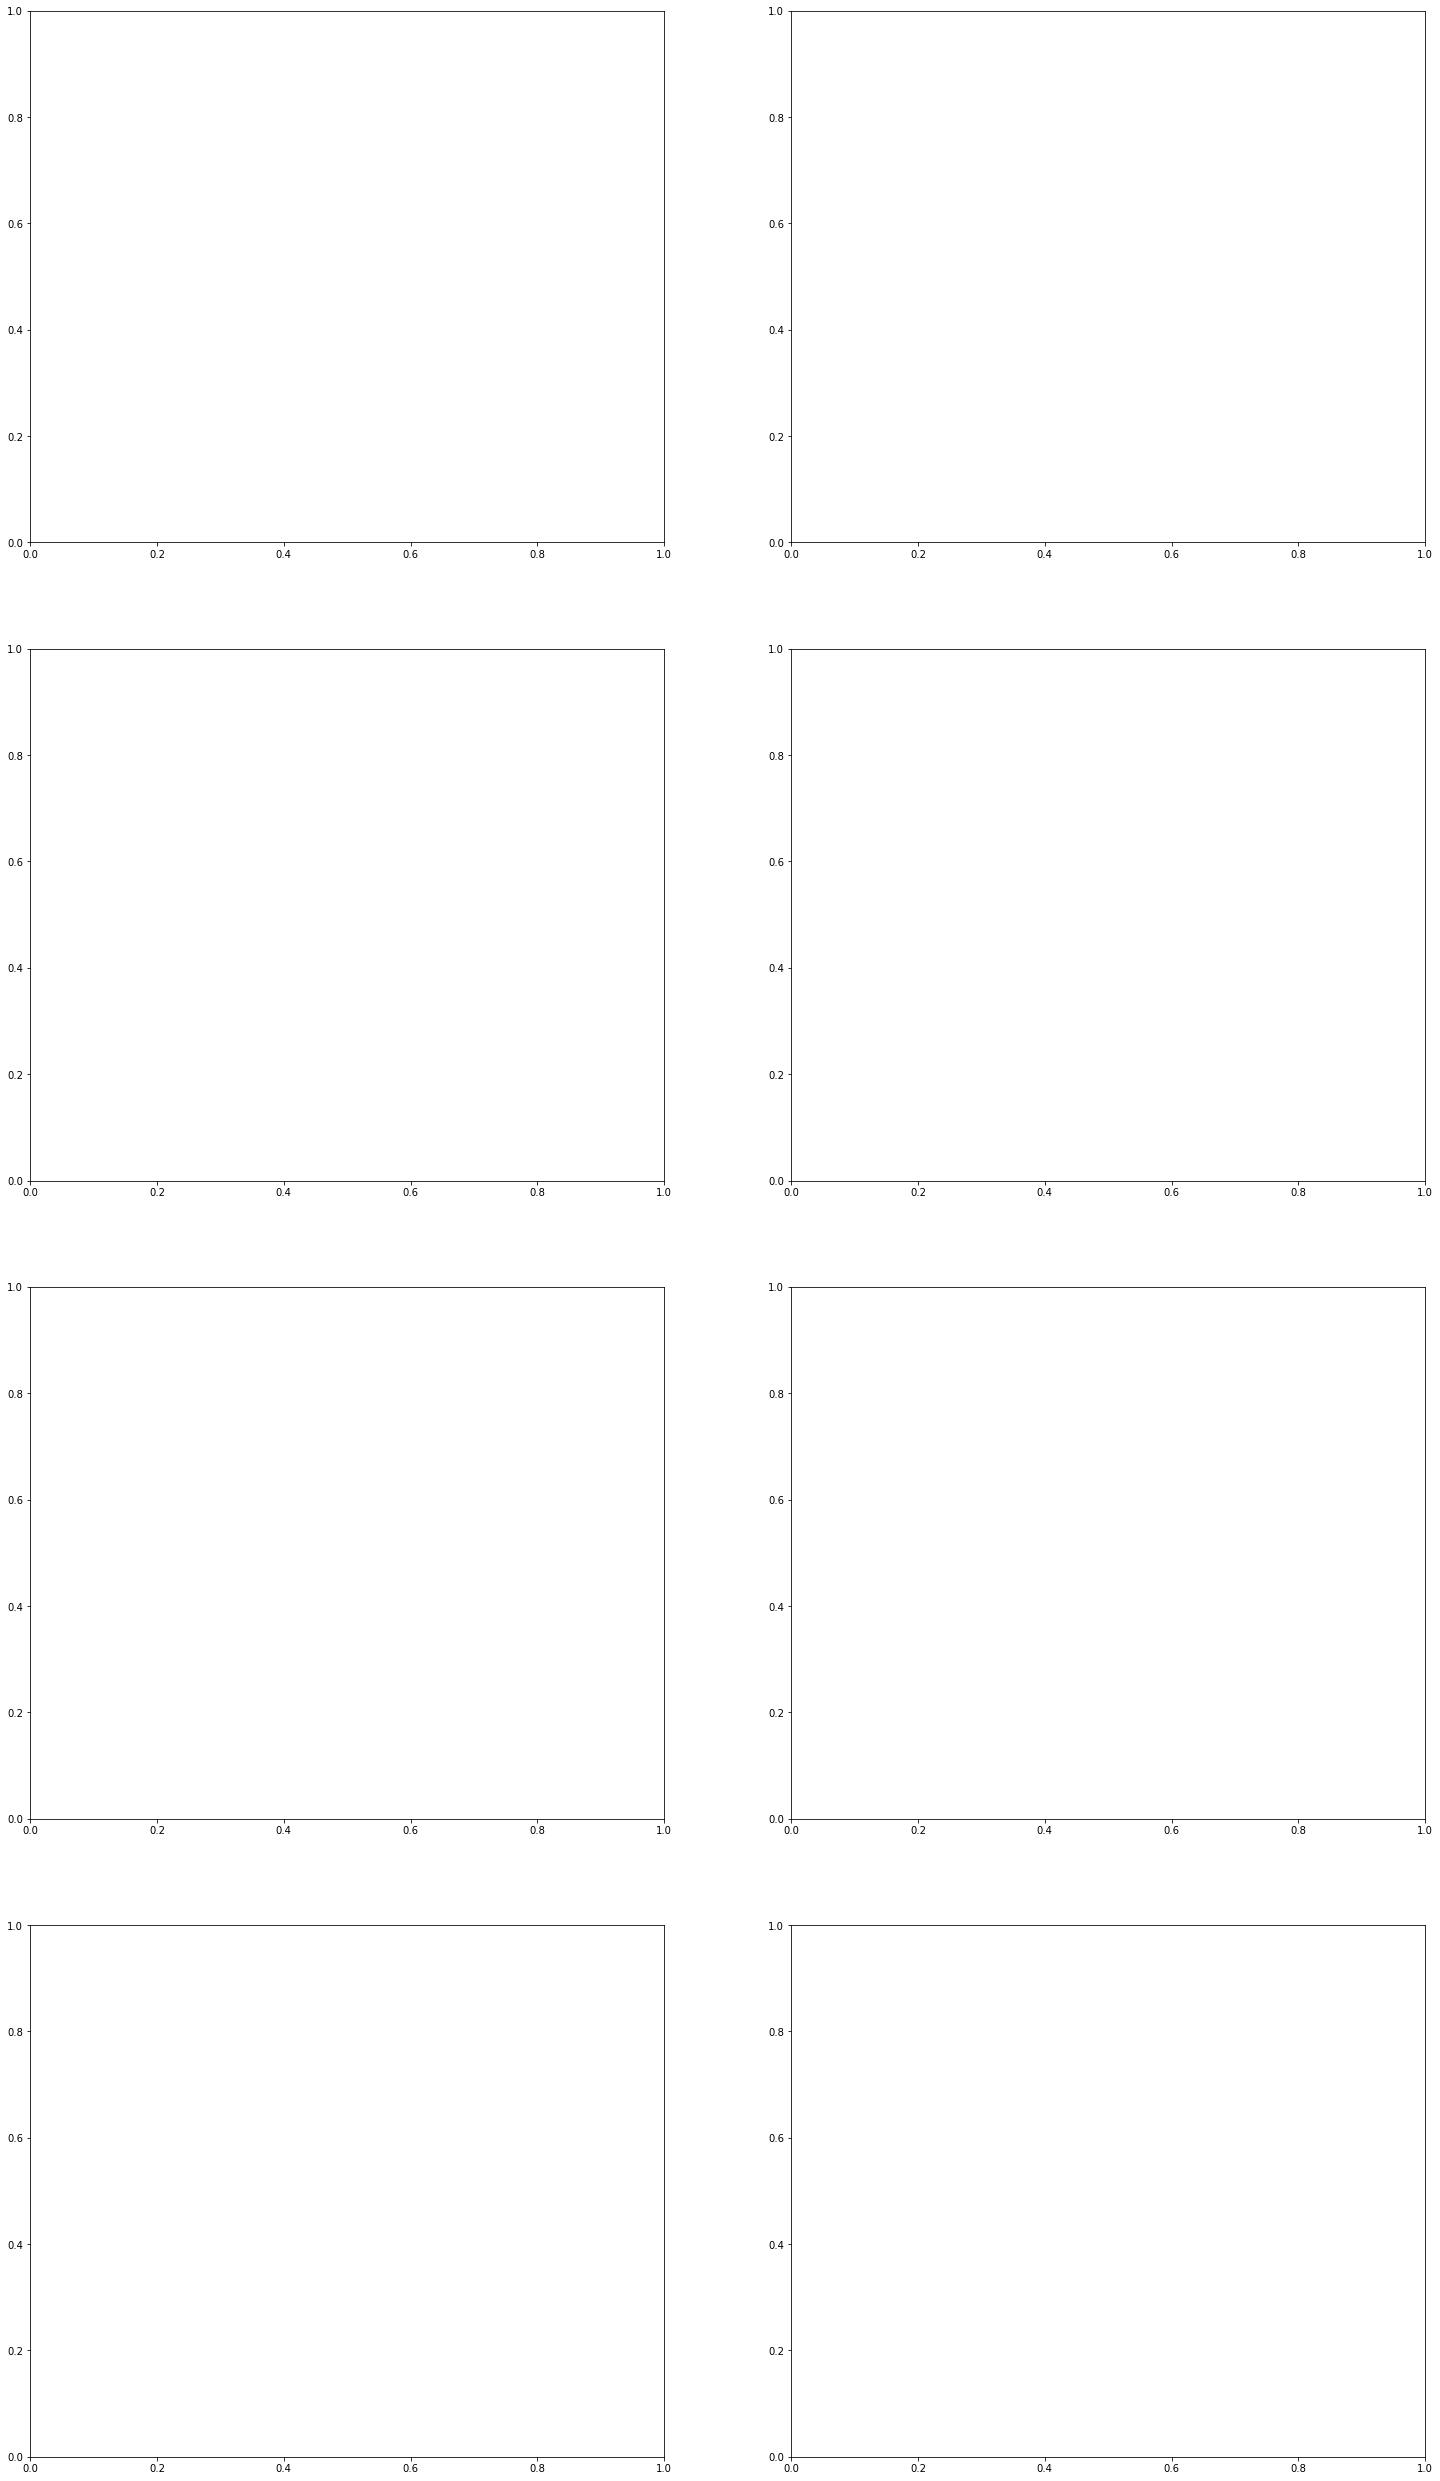

In [84]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

num_skus_per_trans, num_skus_per_trans_plot = barplot(df, *('sku', 'cat', 'qty'), 'price', 'sum', axs[0,0])

mean_price_per_cat, mean_price_per_cat_plot = barplot(df, 'cat', 'price', axs[0,1])

mean_price_per_store, mean_price_per_store_plot = barplot(df, 'store', 'price', axs[1,0])

mean_price_per_day, mean_price_per_day_plot = barplot(df, 'day', 'price', axs[1,1])

mean_price_per_dayofweek, mean_price_per_dayofweek_plot = barplot(df, 'dayofweek', 'price', axs[2,0])

mean_price_per_month, mean_price_per_month_plot = barplot(df, 'month', 'price', axs[2,1])

mean_price_per_weekno, mean_price_per_weekno_plot = barplot(df, 'weekno', 'price', axs[3,0])

In [ ]:
print("Complete run")